In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pickle
import glob
import sys
from scipy import stats
import pandas as pd
import corner
import numpy as np
from astropy.table import Table
import math, scipy
from scipy.interpolate import interp1d
import pyccl as ccl
sys.path.append('../../pinocchio/')   
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme
sys.path.append('../../modules/')
import class_richness_mass_relation as rm_relation
import cosmology
sys.path.append('../../modules/likelihood/')
import model_cluster_abundance as cl_count
import model_cluster_abundance
import model_stacked_cluster_mass
import forecast

# Define Count and lensing mass models

In [2]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [3]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
redshift_edges = np.linspace(0.2, 1, 3)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 20))
Z_bin = binning(redshift_edges)
Richness_bin = binning(richness_edges)

In [4]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

In [5]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef, mass_def_strict=True)
CosmologyObject = cosmology.Cosmology(hmf=hmd, bias_model=halobias_fct)

In [6]:
RM_count_and_mass = rm_relation.Richness_mass_relation()
RM_count_and_mass.select(which = 'log_normal_poisson_log_scatter')

In [7]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 201)

In [8]:
clc = model_cluster_abundance.ClusterAbundance(CosmologyObject = CosmologyObject, MoRObject = RM_count_and_mass)
clm = model_stacked_cluster_mass.ClusterStackedMass(CosmologyObject = CosmologyObject, MoRObject = RM_count_and_mass)

In [9]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
          'compute_dNdzdlogMdOmega_log_slope': False}

In [10]:
def model_count(theta):
    Om, s8 = theta
    cosmox = ccl.Cosmology(Omega_c = Om - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = s8, n_s=0.96)
    params = {'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmox,}
    count_modelling_new = clc.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
    integrand_count = clc.define_count_integrand(count_modelling_new, adds)
    Omega = 0.25*(4*np.pi)
    Nth = Omega * clc.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)
    return Nth
def model_mass(theta, power):
    Om, s8 = theta
    cosmox = ccl.Cosmology(Omega_c = Om - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = s8, n_s=0.96)
    params = {'params_richness_mass_relation': theta_rm,
              'CCL_cosmology': cosmox,}
    count_modelling_new = clc.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
    integrand_count = clc.define_count_integrand(count_modelling_new, adds)
    Omega = 0.25*(4*np.pi)
    Nth = Omega * clc.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)
    NMth = Omega * clm.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = integrand_count,
                                                         grids = grids, integrand = power)
    if power == 'm**(1/3)':  
        Mth = (NMth/Nth)**3
    if power == 'm':  
        Mth = (NMth/Nth)
    return Mth

In [11]:
Count_fiducial = model_count([0.30711, 0.8288])
Mass_fiducial_power = model_mass([0.30711, 0.8288], 'm**(1/3)')
Mass_fiducial = model_mass([0.30711, 0.8288], 'm')

# Simulations

In [12]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
file=glob.glob(where_cat)

In [13]:
def pinocchio_sim(RM, sigma_wl, index_simu=1):
    #generate mass, richness, redshift catalog
    file_sim=file[index_simu]
    dat = pd.read_csv(file_sim ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir_true = dat['ra'], dat['dec'], dat['z'], dat['M']/0.6777
    mask = np.log10(Mvir_true) > 14.2
    ra, dec, redshift, Mvir_true = ra[mask], dec[mask], redshift[mask], Mvir_true[mask]
    log10Mvir_obs = np.log10(Mvir_true) #+ sigma_wl * np.random.randn(len(np.log10(Mvir_true)))
    Mvir = 10**log10Mvir_obs + Mvir_true * sigma_wl * np.random.randn(len(np.log10(Mvir_true)))
    logrichness = RM.lnLambda_random(np.log10(Mvir_true), redshift, theta_rm)
    richness = np.exp(logrichness)
    return redshift, Mvir_true, Mvir, richness

In [49]:
def pinocchio_sim_2RM(RM1, RM2, sigma_wl, index_simu=1):
    #generate mass, richness, redshift catalog
    file_sim=file[index_simu]
    dat = pd.read_csv(file_sim ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir_true = dat['ra'], dat['dec'], dat['z'], dat['M']/0.6777
    mask = np.log10(Mvir_true) > 14.2
    ra, dec, redshift, Mvir_true = ra[mask], dec[mask], redshift[mask], Mvir_true[mask]
    log10Mvir_obs = np.log10(Mvir_true) + sigma_wl * np.random.randn(len(np.log10(Mvir_true)))
    Mvir = 10**log10Mvir_obs 
    logrichness1 = RM1.lnLambda_random(np.log10(Mvir_true), redshift, theta_rm)
    richness1 = np.exp(logrichness1)
    logrichness2 = RM2.lnLambda_random(np.log10(Mvir_true), redshift, theta_rm)
    richness2 = np.exp(logrichness2)
    return redshift, Mvir_true, Mvir, richness1, richness2

In [50]:
RM_test1 = rm_relation.Richness_mass_relation()
RM_test1.select(which = 'log_normal_poisson_scatter')
RM_test2 = rm_relation.Richness_mass_relation()
RM_test2.select(which = 'log_normal_poisson_log_scatter')
redshift, Mvir_true, Mvir, richness1, richness2 = pinocchio_sim_2RM(RM_test1, RM_test2, 0, index_simu=1)

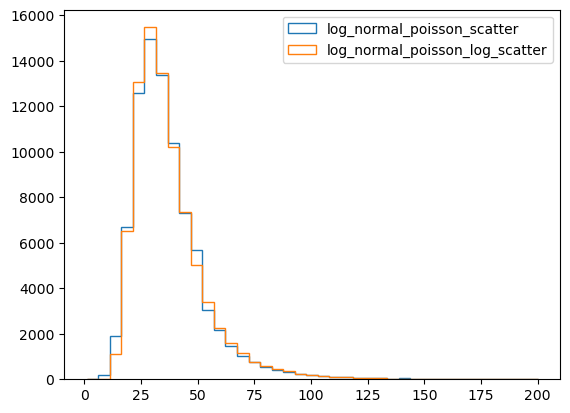

In [51]:
mask = (redshift > 0.2)*(redshift < 1)
plt.hist(richness1[mask], bins = np.linspace(1, 200, 40), histtype='step', label='log_normal_poisson_scatter')
plt.hist(richness2[mask], bins = np.linspace(1, 200, 40), histtype='step', label = 'log_normal_poisson_log_scatter')
plt.legend()
plt.show()

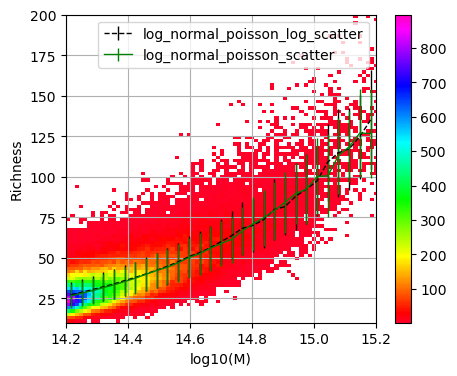

In [65]:
plt.figure(figsize=(5,4))
plt.hist2d(np.log10(Mvir_true), richness2, bins = [np.linspace(14, 16, 150), np.linspace(0, 200, 100)], cmin=1, cmap='gist_rainbow',)
plt.colorbar()
plt.xlabel('log10(M)')
plt.ylabel('Richness')
x = np.linspace(0, 200, 100)
bin_edges = np.linspace(14.2, 15.2, 30)
bin_center = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
bin_means_1, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness2, 'mean', bins=bin_edges)
bin_stds, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness2, 'std', bins=bin_edges)
plt.errorbar(bin_center, bin_means_1,bin_stds, fmt='--k', lw=1, label = 'log_normal_poisson_log_scatter')

bin_means_2, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness1, 'mean', bins=bin_edges)
bin_stds, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness1, 'std', bins=bin_edges)
plt.errorbar(bin_center, bin_means_2,bin_stds, fmt='-g', lw=1, label = 'log_normal_poisson_scatter', elinewidth=1)
plt.ylim(10, 200)
plt.xlim(14.2, 15.2)
plt.grid(which='both')
plt.legend()
#plt.yscale('log')

In [55]:
bin_edges = np.linspace(14.2, 15.2, 50)
bin_center = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
mean_1 = []
mean_2 = []
for i in range(500):
    redshift, Mvir_true, Mvir, richness1, richness2 = pinocchio_sim_2RM(RM_test1, RM_test2, 0, index_simu=i)
    bin_means_1, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness1, 'mean', bins=bin_edges)
    mean_1.append(bin_means_1)
    bin_means_2, bin_edges_, binnumber = stats.binned_statistic(np.log10(Mvir_true), richness2, 'mean', bins=bin_edges)
    mean_2.append(bin_means_2)

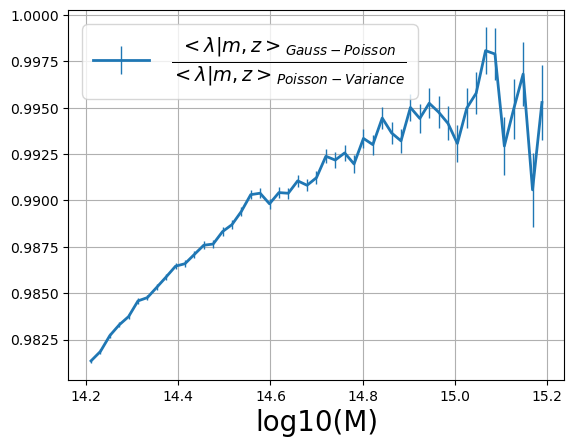

In [62]:
plt.errorbar(bin_center, (np.mean(mean_1, axis=0)/np.mean(mean_2, axis=0)), (np.std(mean_1, axis=0)/(np.sqrt(500)*np.mean(mean_2, axis=0))),
             lw=2, elinewidth=1, label = r'$\frac{<\lambda|m,z>_{Gauss-Poisson}}{<\lambda|m,z>_{Poisson-Variance}}$')
plt.xlabel('log10(M)', fontsize=20)
plt.legend(fontsize=20)
plt.grid()

In [20]:
def summary_statistics(RM_model, sigma_wl_mass, n_simu=1):
    N_richness_redshift = np.zeros([len(richness_edges)-1, len(redshift_edges)-1, n_simu])
    M_power_richness_redshift = np.zeros([len(richness_edges)-1, len(redshift_edges)-1, n_simu])
    M_richness_redshift = np.zeros([len(richness_edges)-1, len(redshift_edges)-1, n_simu])
    for i in range(n_simu):
        redshift, Mvir_true, Mvir, richness= pinocchio_sim(RM_model, sigma_wl_mass, index_simu=i)
        N_richness_redshift_, a, b = np.histogram2d(richness, redshift, bins = [richness_edges, redshift_edges, ])
        N_richness_redshift[:,:,i] = N_richness_redshift_
        
        M_richness_redshift_ = stats.binned_statistic_2d(richness, redshift, Mvir, 'mean', 
                                                                 bins=[richness_edges, redshift_edges]).statistic
        M_richness_redshift[:,:,i] = M_richness_redshift_
        
        M_power_richness_redshift_ = stats.binned_statistic_2d(richness, redshift, Mvir**(1/3), 'mean', 
                                                                 bins=[richness_edges, redshift_edges]).statistic**3
        M_power_richness_redshift[:,:,i] = M_power_richness_redshift_
    
    return N_richness_redshift, M_richness_redshift, M_power_richness_redshift 

In [47]:
RM_Poisson_variance = rm_relation.Richness_mass_relation()
RM_Poisson_variance.select(which = 'log_normal_poisson_log_scatter')

RM_GaussPoiss = rm_relation.Richness_mass_relation()
RM_GaussPoiss.select(which = 'log_normal_poisson_scatter')
n_simu = 300
sigma_wl=0
N_richness_redshift_Poisson_variance, M_richness_redshift_Poisson_variance, M_power_richness_redshift_Poisson_variance = summary_statistics(RM_Poisson_variance, sigma_wl, n_simu=n_simu)
N_richness_redshift_GaussPoiss, M_richness_redshift_GaussPoiss, M_power_richness_redshift_GaussPoiss = summary_statistics(RM_GaussPoiss, sigma_wl, n_simu=n_simu)

(-20.0, 20.0)

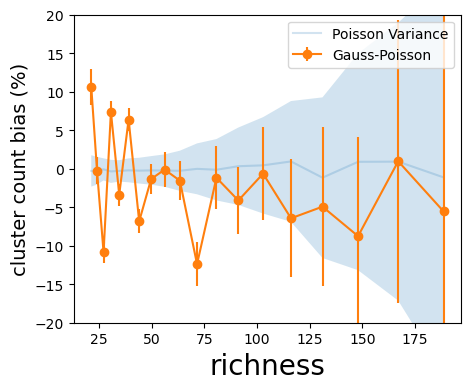

In [48]:
plt.figure(figsize=(5,4))
richness_bin_center = np.mean(Richness_bin, axis=1)
for i in range(len(Z_bin)):
    y = 100*(np.mean(N_richness_redshift_Poisson_variance[:,i,:], axis=1) - Count_fiducial[:,i])/Count_fiducial[:,i]
    y_err = 100*np.std(N_richness_redshift_Poisson_variance[:,i,:], axis=1)/Count_fiducial[:,i]
    plt.plot(richness_bin_center, y, label = 'Poisson Variance', alpha=.2)
    plt.fill_between(richness_bin_center, y+y_err, y-y_err, alpha=.2)

    y = 100*(np.mean(N_richness_redshift_GaussPoiss[:,i,:], axis=1) - Count_fiducial[:,i] )/Count_fiducial[:,i]
    y_err = 100*np.std(N_richness_redshift_GaussPoiss[:,i,:], axis=1)/Count_fiducial[:,i]
    plt.errorbar(richness_bin_center , y, y_err, marker = 'o', label = 'Gauss-Poisson')
    break

plt.ylabel('cluster count bias (%)', fontsize=14,)
plt.xlabel('richness', fontsize=20,)
plt.legend()
plt.ylim(-20, 20)

In [36]:
sigma_wl=0.25/np.log(10)
res = summary_statistics(RM_Poisson_variance, sigma_wl, n_simu=n_simu)
N_richness_redshift_Poisson_variance_sigma_wl, M_richness_redshift_Poisson_variance_sigma_wl, M_power_richness_redshift_Poisson_variance_sigma_wl = res
res = summary_statistics(RM_GaussPoiss, sigma_wl, n_simu=n_simu)
N_richness_redshift_GaussPoiss_sigma_wl, M_richness_redshift_GaussPoiss_sigma_wl, M_power_richness_redshift_GaussPoiss_sigma_wl = res

(-5.0, 20.0)

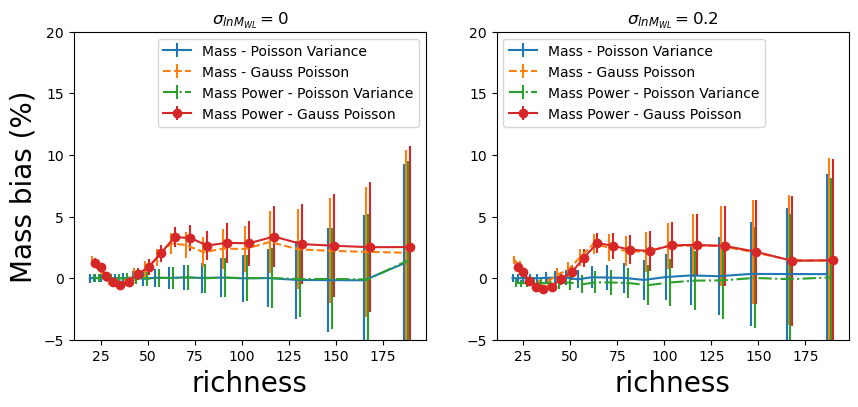

In [66]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title(r'$\sigma_{lnM_{WL}} = 0$')
for i in range(len(Z_bin)):
    y = 100*(np.mean(M_richness_redshift_Poisson_variance[:,i], axis=1) - Mass_fiducial[:,i])/Mass_fiducial[:,i]
    y_err = 100*(np.std(M_richness_redshift_Poisson_variance[:,i], axis=1))/Mass_fiducial[:,i]
    plt.errorbar(richness_bin_center-2, y, y_err, fmt='-', label = 'Mass - Poisson Variance')

    y = 100*( np.mean(M_richness_redshift_GaussPoiss[:,i], axis=1) - Mass_fiducial[:,i])/Mass_fiducial[:,i]
    y_err = 100*(np.std(M_richness_redshift_GaussPoiss[:,i], axis=1))/Mass_fiducial[:,i]
    plt.errorbar(richness_bin_center-1, y, y_err, fmt='--', label = 'Mass - Gauss Poisson')

    y = 100*( np.mean(M_power_richness_redshift_Poisson_variance[:,i], axis=1) - Mass_fiducial_power[:,i])/Mass_fiducial_power[:,i]
    y_err = 100*(np.std(M_power_richness_redshift_Poisson_variance[:,i], axis=1))/Mass_fiducial_power[:,i]
    plt.errorbar(richness_bin_center, y, y_err, fmt='-.',  label = 'Mass Power - Poisson Variance')

    y = 100*( np.mean(M_power_richness_redshift_GaussPoiss[:,i], axis=1)- Mass_fiducial_power[:,i])/Mass_fiducial_power[:,i]
    y_err = 100*(np.std(M_power_richness_redshift_GaussPoiss[:,i], axis=1))/Mass_fiducial_power[:,i]
    plt.errorbar(richness_bin_center+1, y, y_err, fmt='-o',  label = 'Mass Power - Gauss Poisson')
    break

plt.ylabel('Mass bias (%)', fontsize=20,)
plt.xlabel('richness', fontsize=20,)
plt.legend()
plt.ylim(-5, 20)

plt.subplot(122)
plt.title(r'$\sigma_{lnM_{WL}} = 0.2$')
for i in range(len(Z_bin)):
    y = 100*(np.mean(M_richness_redshift_Poisson_variance_sigma_wl[:,i], axis=1) - Mass_fiducial[:,i])/Mass_fiducial[:,i]
    y_err = 100*(np.std(M_richness_redshift_Poisson_variance[:,i], axis=1))/Mass_fiducial[:,i]
    plt.errorbar(richness_bin_center-2, y, y_err, fmt='-', label = 'Mass - Poisson Variance')

    y = 100*(np.mean(M_richness_redshift_GaussPoiss_sigma_wl[:,i], axis=1) - Mass_fiducial[:,i])/Mass_fiducial[:,i]
    y_err = 100*(np.std(M_richness_redshift_GaussPoiss[:,i], axis=1))/Mass_fiducial[:,i]
    plt.errorbar(richness_bin_center-1, y, y_err, fmt='--', label = 'Mass - Gauss Poisson')

    y = 100*(np.mean(M_power_richness_redshift_Poisson_variance_sigma_wl[:,i], axis=1) - Mass_fiducial_power[:,i])/Mass_fiducial_power[:,i]
    y_err = 100*(np.std(M_power_richness_redshift_Poisson_variance[:,i], axis=1))/Mass_fiducial_power[:,i]
    plt.errorbar(richness_bin_center, y, y_err, fmt='-.',  label = 'Mass Power - Poisson Variance')

    y = 100*(np.mean(M_power_richness_redshift_GaussPoiss_sigma_wl[:,i], axis=1) - Mass_fiducial_power[:,i])/Mass_fiducial_power[:,i]
    y_err = 100*(np.std(M_power_richness_redshift_GaussPoiss[:,i], axis=1))/Mass_fiducial_power[:,i]
    plt.errorbar(richness_bin_center+1, y, y_err, fmt='-o',  label = 'Mass Power - Gauss Poisson')
    break

plt.xlabel('richness', fontsize=20,)
plt.legend(loc='upper left')
plt.ylim(-5, 20)